# **Audio Classification with TensorFlow**

# Importing Libraries

In [1]:
!pip install -q pydub
!pip install tensorflow-datasets
!pip install ipython
!pip install tqdm

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

from IPython.display import Audio
from matplotlib import pyplot as plt
from tqdm import tqdm

print(tf.__version__)
print(tfds.__version__)

2.5.0
4.0.1


In [3]:
dataset = tfds.load("gtzan_music_speech")

Shuffling and writing examples to /root/tensorflow_datasets/gtzan_music_speech/1.0.0.incompleteSBX62X/gtzan_music_speech-train.tfrecord


Dataset gtzan_music_speech downloaded and prepared to /root/tensorflow_datasets/gtzan_music_speech/1.0.0. Subsequent calls will reuse this data.


# Explore the Data

In [4]:
train = dataset["train"]

data_iter = iter(train)

In [5]:
example = next(data_iter)

example

{'audio': <tf.Tensor: shape=(661500,), dtype=int64, numpy=array([-2821, -3743, -4288, ...,  -717,   132,  1548])>,
 'audio/filename': <tf.Tensor: shape=(), dtype=string, numpy=b'vlobos.wav'>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}

In [6]:
audio = example.get("audio")
label = example.get("label")

print(label.numpy())

Audio(audio, rate=22050)

0


In [7]:
index_to_class = {0: "music", 1: "speech"}
class_to_index = {"music": 0, "speech": 1}

In [8]:
def plot_waveform(audio):
    plt.plot(audio)
    plt.xlabel("samples")
    plt.ylabel("amplitude")
    plt.show()

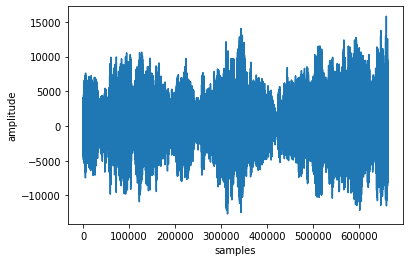

In [9]:
plot_waveform(audio.numpy())

# Spectrogram

In [10]:
def get_stft(audio, frame_length=2048, frame_step=512, fft_length=256):
    return tf.signal.stft(
        tf.cast(audio, tf.float32),
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length
    )

In [11]:
audio_stft = get_stft(audio)
audio_spec = tf.abs(audio_stft)

In [12]:
def plot_spec(spec):
    plt.figure(figsize=(12, 4))
    plt.imshow(tf.transpose(spec), cmap="viridis")
    plt.colorbar()
    plt.show()

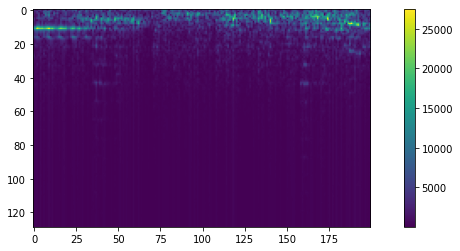

In [13]:
plot_spec(audio_spec[:200])

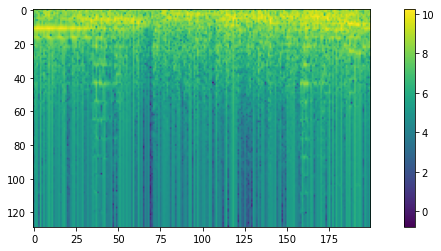

In [14]:
audio_spec_log = tf.math.log(audio_spec)

plot_spec(audio_spec_log[:200])

In [15]:
def get_spectrogram(audio):
    audio_stft = get_stft(audio)
    audio_spec = tf.abs(audio_stft)
    return tf.math.log(tf.transpose(audio_spec))

# Prepare the Data

In [16]:
sr = 22050 # samples per second
chunk_len = 5 # seconds


def preprocess_example(example):
    audio = example.get("audio")
    label = example.get("label")

    x_batch, y_batch = None, None

    for j in range(0, 6):
        audio_chunk = audio[j * chunk_len * sr: (j + 1) * chunk_len * sr]
        audio_spec = get_spectrogram(audio_chunk)
        audio_spec = tf.expand_dims(audio_spec, axis=0)
        current_label = tf.expand_dims(label, axis=0)
        
        x_batch = audio_spec if x_batch is None else tf.concat([x_batch, audio_spec], axis=0)
        y_batch = current_label if y_batch is None else tf.concat([y_batch, current_label], axis=0)
    return x_batch, y_batch

In [17]:
x_train, y_train = None, None


for example in tqdm(iter(train)):
    x_batch, y_batch = preprocess_example(example)
    
    x_train = x_batch if x_train is None else tf.concat([x_train, x_batch], axis=0)
    y_train = y_batch if y_train is None else tf.concat([y_train, y_batch], axis=0)

128it [00:04, 27.80it/s]


In [18]:
print(x_train.shape, y_train.shape)

(768, 129, 212) (768,)


In [19]:
indices = tf.random.shuffle(list(range(0, 768)))

x_train = tf.gather(x_train, indices)
y_train = tf.gather(y_train, indices)

n_val = 300

x_valid = x_train[:n_val, ...]
y_valid = y_train[:n_val, ...]

x_train = x_train[n_val:, ...]
y_train = y_train[n_val:, ...]

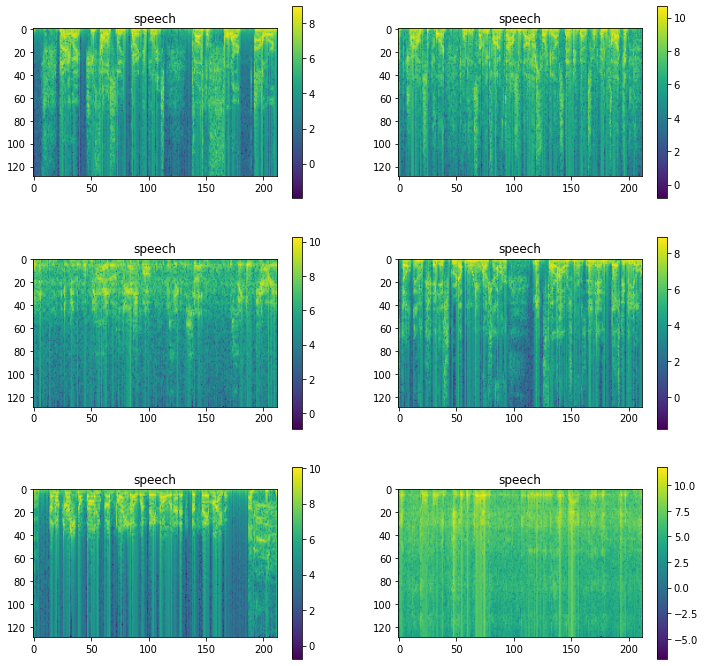

In [20]:
plt.figure(figsize=(12, 12))

st = 0

for i in range(0, 6):
    x, y = x_train[st + i], y_train[st + i]

    plt.subplot(3, 2, i + 1)
    plt.imshow(x, cmap="viridis")
    plt.title(index_to_class[y.numpy()])
    plt.colorbar()
plt.show()

# Create the Model

In [21]:
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPool2D, Flatten, Dropout, Dense


input_ = Input(shape=(129, 212))
x = Lambda(lambda x: tf.expand_dims(x, axis=-1))(input_)

for i in range(0, 4):
    n_filters = 2**(5 + i)
    x = Conv2D(n_filters, 3)(x)
    x = BatchNormalization()(x)
    x = Activation("tanh")(x)
    x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(1, activation="sigmoid")(x)

model = tf.keras.models.Model(input_, x)

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-6),
    loss="binary_crossentropy", metrics=["accuracy"]
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 129, 212)]        0         
_________________________________________________________________
lambda (Lambda)              (None, 129, 212, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 127, 210, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 210, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 127, 210, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 105, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 103, 64)       18496 

# Model Training

In [23]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, *args, **kwargs):
        super(CustomCallback, self).__init__(*args, **kwargs)
        self.target_acc = kwargs.get("target_acc") or 0.95
        self.log_epoch = kwargs.get("log_epoch") or 5

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get("loss")
        acc = logs.get("accuracy")
        val_loss = logs.get("val_loss")
        val_acc = logs.get("val_accuracy")

        if (epoch + 1) % self.log_epoch == 0:
            print(f"Epoch: {epoch:3d}, Loss: {loss:.4f}, Acc: {acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc >= self.target_acc:
            print("Target val accuracy achieved", val_acc)
            model.stop_training = True

In [24]:
_ = model.fit(
    x_train, y_train,
    batch_size=12,
    epochs=500,
    validation_data=(x_valid, y_valid),
    verbose=False,
    callbacks=[CustomCallback()]
)

Epoch:   4, Loss: 0.5610, Acc: 0.7222, Val Loss: 0.7348, Val Acc: 0.6000
Epoch:   9, Loss: 0.5082, Acc: 0.7393, Val Loss: 0.4255, Val Acc: 0.8267
Epoch:  14, Loss: 0.4254, Acc: 0.8056, Val Loss: 0.3796, Val Acc: 0.8333
Epoch:  19, Loss: 0.3906, Acc: 0.8120, Val Loss: 0.3557, Val Acc: 0.8633
Epoch:  24, Loss: 0.3245, Acc: 0.8590, Val Loss: 0.3250, Val Acc: 0.8733
Epoch:  29, Loss: 0.3216, Acc: 0.8504, Val Loss: 0.2937, Val Acc: 0.8967
Epoch:  34, Loss: 0.2602, Acc: 0.9103, Val Loss: 0.2640, Val Acc: 0.9100
Epoch:  39, Loss: 0.2385, Acc: 0.9124, Val Loss: 0.2432, Val Acc: 0.9133
Epoch:  44, Loss: 0.2105, Acc: 0.9359, Val Loss: 0.2249, Val Acc: 0.9200
Epoch:  49, Loss: 0.1819, Acc: 0.9274, Val Loss: 0.2095, Val Acc: 0.9233
Epoch:  54, Loss: 0.1476, Acc: 0.9487, Val Loss: 0.1897, Val Acc: 0.9233
Epoch:  59, Loss: 0.1261, Acc: 0.9615, Val Loss: 0.1774, Val Acc: 0.9267
Epoch:  64, Loss: 0.1130, Acc: 0.9701, Val Loss: 0.1617, Val Acc: 0.9300
Epoch:  69, Loss: 0.1241, Acc: 0.9530, Val Loss: 0.

# Predictions

In [25]:
example = next(data_iter)

x_test, y_test = preprocess_example(example)

preds = model.predict(x_test)
pred_classes = tf.squeeze(tf.cast(preds > 0.5, tf.int8))

print("Preds:", [index_to_class[c.numpy()] for c in pred_classes])
print("GT:", [index_to_class[c.numpy()] for c in y_test])

Preds: ['music', 'music', 'music', 'music', 'music', 'music']
GT: ['music', 'music', 'music', 'music', 'music', 'music']
